# Evaluation of experiments - E1 COGNITION
fistly define the UUID of the experiment to use

In [1]:
experimentId="ee715b34-ba07-49f0-9102-9652bb173c6c"

-------------------------------------------------------

In [2]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## Override metrics to do classical F1 instead of F1*

In [3]:
def annotationPairToMetrics(annotations,detections,thresIoU=0.3):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    #binarize
    binarized=iouMatrix>thresIoU
    #calculateF1 the old way
    N=len(annotations)
    M=len(detections)
    TP=np.sum(np.max(binarized,axis=0))
    FN=N-TP
    FP=M-TP

    outF1=(2*TP)/(2*TP+FN+FP)
    recall=TP/N
    precision=TP/M

    #calculateF1*
    """ outF1=(np.sum(np.max(binarized,axis=0))+np.sum(np.max(binarized,axis=1)))/(len(annotations)+len(detections))
    recall=np.sum(np.max(binarized,axis=1))/len(annotations)
    precision=np.sum(np.max(binarized,axis=0))/len(detections) """
    return outF1,recall,precision

## load cognition

In [4]:
samplerate=200  #Should rethink this

In [5]:
annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath)

In [6]:
annotations=annotations[annotations.type=='spindle'].reset_index(drop=True)
len(annotations)

2785

In [7]:
durations=signalsMetadata.duration
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


## Load experiment results

In [8]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [9]:
experimentModels.head()

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,a4659423-83e4-4da3-91b5-177fa8bc17fe,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,ad3be387-5be4-4e8e-b57d-072003b617d3,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,8bcbbc8b-b83e-4b97-8f7c-0dd0760680e7,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,f88ed731-de3a-4c9a-90d5-04d1fcd93d45,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,16a691da-d735-4ad2-953c-db2678980107,0.010340


In [10]:
featureSelection

,window,characteristic,bandName,Times_selected
0,2,sigmaIndex,broadband,1000.0
1,2,hjortActivity,sigma,1000.0
2,1.5,sigmaIndex,broadband,1000.0
3,1,hjortActivity,sigma,1000.0
4,1,sigmaIndex,broadband,1000.0
5,2,hjortActivity,beta1,1000.0
6,2,hjortActivity,beta2,1000.0
7,1.5,hjortActivity,sigma,999.0
8,2,hjortMobility,beta1,994.0
9,2,hjortActivity,delta2,986.0


## Optimal hyperparameter estimation with E1 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [11]:
experimentModels=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,a4659423-83e4-4da3-91b5-177fa8bc17fe,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,ad3be387-5be4-4e8e-b57d-072003b617d3,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,8bcbbc8b-b83e-4b97-8f7c-0dd0760680e7,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,f88ed731-de3a-4c9a-90d5-04d1fcd93d45,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,16a691da-d735-4ad2-953c-db2678980107,0.010340
5,0001,E1,[0001],"[0002, 0004, 0005, 0008]","[0003, 0006]",0007,d91f41ff-0308-46df-9bcd-67d46f377777,0.006673
6,0001,E1,[0001],"[0002, 0005, 0006, 0007]","[0003, 0004]",0008,a1eacac2-9e31-437a-9350-110d2ef2f1a5,0.006822


In [12]:
experimentModels_N2 = experimentModels.copy()
experimentModels_N2.head()

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0004, 0005, 0006, 0007]","[0003, 0008]",0002,a4659423-83e4-4da3-91b5-177fa8bc17fe,0.008075
1,0001,E1,[0001],"[0002, 0005, 0006, 0008]","[0007, 0004]",0003,ad3be387-5be4-4e8e-b57d-072003b617d3,0.005000
2,0001,E1,[0001],"[0002, 0003, 0005, 0007]","[0006, 0008]",0004,8bcbbc8b-b83e-4b97-8f7c-0dd0760680e7,0.012035
3,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0006, 0004]",0005,f88ed731-de3a-4c9a-90d5-04d1fcd93d45,0.010340
4,0001,E1,[0001],"[0002, 0003, 0007, 0008]","[0004, 0005]",0006,16a691da-d735-4ad2-953c-db2678980107,0.010340


In [13]:
auxThres=pd.DataFrame({
    'hyperThres':[0.1,0.2,0.3,0.4,0.5,0.6]
})
auxDepth=pd.DataFrame({
    'hyperDepth':[5,10,15,20,30,40]
})
auxMinDuration=pd.DataFrame({
    'hyperMinDuration':[0.3]
})
auxMaxDuration=pd.DataFrame({
    'hyperMaxDuration':[5]
})
auxClose=pd.DataFrame({
    'hyperClose':[0.1]
})


hyperParams=pd.merge(auxThres,auxDepth,how='cross')
hyperParams=pd.merge(hyperParams,auxMinDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxMaxDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxClose,how='cross')

hyperParams

,hyperThres,hyperDepth,hyperMinDuration,hyperMaxDuration,hyperClose
0,0.1,5,0.3,5,0.1
1,0.1,10,0.3,5,0.1
2,0.1,15,0.3,5,0.1
3,0.1,20,0.3,5,0.1
4,0.1,30,0.3,5,0.1
5,0.1,40,0.3,5,0.1
6,0.2,5,0.3,5,0.1
7,0.2,10,0.3,5,0.1
8,0.2,15,0.3,5,0.1
9,0.2,20,0.3,5,0.1


In [14]:
rawF1s = []
rawPrecisions = []
rawRecalls = []

rawThres = []
rawDepth = []

f1s = []
precisions = []
recalls = []

eventF1s = []
eventPrecisions = []
eventRecalls = []

checks = []

rawF1s_N2 = []
rawPrecisions_N2 = []
rawRecalls_N2 = []

f1s_N2 = []
precisions_N2 = []
recalls_N2 = []

eventF1s_N2 = []
eventPrecisions_N2 = []
eventRecalls_N2 = []

checks_N2 = []

allDetections=[]
allAnnotations=[]
allDetections_N2=[]
allAnnotations_N2=[]

thisExperimentModels = experimentModels.copy()
for ind, row in thisExperimentModels.iterrows():
    #load model
    print(ind)
    model = loadBooster(row.modelId, experimentId, datapath)
    #initialise lists
    rawF1xs=[]

    

    #iterate validation subjects
    for valSubjectId in row.val:
        print(valSubjectId)
        #Define annotations criterium
        usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
        #Load features and labels
        valFeatures=loadFeatureMatrix([valSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
        valLabels=loadLabelsVector([valSubjectId],usedAnnotations,signalsMetadata,samplerate)
        #Predict
        valDMatrix=xgb.DMatrix(data=valFeatures)
        probabilities=[]
        for i_depth, j_depth in auxDepth.iterrows():
            pred=model.predict(valDMatrix,iteration_range=(0,int(j_depth['hyperDepth'])))
            probabilities.append(pred)
        probabilities=np.array(probabilities)
        f1xs=[]

        
        for ind_hyper,row_hyper in hyperParams.iterrows():
            thisExperimentModels=experimentModels.copy()
            hyperThres=row_hyper.hyperThres
            hyperDepth=int(row_hyper.hyperDepth)
            hyperMinDuration=row_hyper.hyperMinDuration
            hyperMaxDuration=row_hyper.hyperMaxDuration
            hyperClose=row_hyper.hyperClose
            probs=probabilities[auxDepth['hyperDepth']==hyperDepth][0]
            raw=probs>=hyperThres
            #Processed labels
            processed=labelingProcess(raw,hyperClose,hyperMinDuration,samplerate)
            gtAnnotations=labelVectorToAnnotations(valLabels,samplerate)
            detections=labelVectorToAnnotations(processed,samplerate)
            detections=detections[detections.duration<hyperMaxDuration]
            #Metrics
            f,r,p=annotationPairToMetrics(gtAnnotations,detections, thresIoU=0.2)
        
            #Metric appends
            f1xs.append(f)

        rawF1xs.append(np.array(f1xs))

    #statistics of the metrics over the subjects of the validation set
    meanF1s=np.mean(np.array(rawF1xs), axis=0)
    
    optimalInd=hyperParams[meanF1s==np.max(meanF1s)].iloc[0]
    hyperParams_opt=optimalInd
    print(hyperParams_opt)
    hyperThres=hyperParams_opt['hyperThres']
    hyperDepth=int(hyperParams_opt['hyperDepth'])
    hyperMinDuration=hyperParams_opt['hyperMinDuration']
    hyperMaxDuration=hyperParams_opt['hyperMaxDuration']
    hyperClose=hyperParams_opt['hyperClose']
    
    ##
    rawThres.append(hyperThres)
    rawDepth.append(hyperDepth)


    testSubjectId=row.test
    
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)
    
    
    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres
    #Raw Metrics
    rawTp=np.sum(rawLabels*testLabels)
    rawFp=np.sum(rawLabels*(1-testLabels))
    rawTn=np.sum((1-rawLabels)*(1-testLabels))
    rawFn=np.sum((1-rawLabels)*testLabels)
    #Raw appends
    rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
    rawPrecisions.append(rawTp/(rawTp+rawFp) )
    rawRecalls.append(rawTp/(rawTp+rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp=np.sum(processedLabels*testLabels)
    fp=np.sum(processedLabels*(1-testLabels))
    tn=np.sum((1-processedLabels)*(1-testLabels))
    fn=np.sum((1-processedLabels)*testLabels)
    #Processed appends
    f1s.append(2*tp/(2*tp+fp+fn))
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations=processedAnnotations[processedAnnotations.duration<hyperMaxDuration]
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    f,r,p=annotationPairToMetrics(gtAnnotations,processedAnnotations, thresIoU=0.2)
    print('F1-score')
    print(f)
    #calculate metrics
    eventF1s.append(f)
    eventPrecisions.append(p)
    eventRecalls.append(r)
    
    allDetections.append(processedAnnotations)
    allAnnotations.append(gtAnnotations)
    
    #N2
    
    hypnogram=loadCOGNITIONHypnogram(testSubjectId,cognipath)

    #Load labels
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)
    
    testLabels=testLabels*(hypnogram==2)

    rawLabels=rawLabels*(hypnogram==2)


    
    #Raw Metrics
    rawTp = np.sum(rawLabels * testLabels)
    rawFp = np.sum(rawLabels * (1 - testLabels))
    rawTn = np.sum((1 - rawLabels) * (1 - testLabels))
    rawFn = np.sum((1 - rawLabels) * testLabels)
    #Raw appends
    rawF1s_N2.append(2 * rawTp / (2 * rawTp + rawFp + rawFn))
    rawPrecisions_N2.append(rawTp / (rawTp + rawFp))
    rawRecalls_N2.append(rawTp / (rawTp + rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp = np.sum(processedLabels * testLabels)
    fp = np.sum(processedLabels * (1 - testLabels))
    tn = np.sum((1 - processedLabels) * (1 - testLabels))
    fn = np.sum((1 - processedLabels) * testLabels)
    #Processed appends
    f1s_N2.append(2 * tp / (2 * tp + fp + fn))
    precisions_N2.append(tp / (tp + fp))
    recalls_N2.append(tp / (tp + fn))

    #By-event metrics
    processedAnnotations = labelVectorToAnnotations(processedLabels, samplerate)
    gtAnnotations = labelVectorToAnnotations(testLabels, samplerate)  #<- or just filter the annotations
    f, r, p = annotationPairToMetrics(gtAnnotations, processedAnnotations, thresIoU=0.2)
    print('N2 F1-score')
    print(f)
    #calculate metrics
    eventF1s_N2.append(f)
    eventPrecisions_N2.append(p)
    eventRecalls_N2.append(r)
    
    allDetections_N2.append(processedAnnotations)
    allAnnotations_N2.append(gtAnnotations)

#include metrics in the dataframe
experimentModels['rawF1'] = rawF1s
experimentModels['rawPrecision'] = rawPrecisions
experimentModels['rawRecall'] = rawRecalls

experimentModels['f1'] = f1s
experimentModels['precision'] = precisions
experimentModels['recall'] = recalls

experimentModels['eventF1'] = eventF1s
experimentModels['eventPrecision'] = eventPrecisions
experimentModels['eventRecall'] = eventRecalls

experimentModels['Binarization_Threshold'] = rawF1s
experimentModels['Boosting_Iterations'] = rawPrecisions
#include metrics in the N2 dataframe
experimentModels_N2['rawF1'] = rawF1s_N2
experimentModels_N2['rawPrecision'] = rawPrecisions_N2
experimentModels_N2['rawRecall'] = rawRecalls_N2

experimentModels_N2['f1'] = f1s_N2
experimentModels_N2['precision'] = precisions_N2
experimentModels_N2['recall'] = recalls_N2

experimentModels_N2['eventF1'] = eventF1s_N2
experimentModels_N2['eventPrecision'] = eventPrecisions_N2
experimentModels_N2['eventRecall'] = eventRecalls_N2

experimentModels_N2['Binarization_Threshold'] = rawF1s
experimentModels_N2['Boosting_Iterations'] = rawPrecisions

0
0003
0008
hyperThres           0.2
hyperDepth          10.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 7, dtype: float64
F1-score
0.697560975609756
N2 F1-score
0.7299703264094956
1
0007
0004
hyperThres           0.4
hyperDepth          10.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 19, dtype: float64
F1-score
0.862789384528515
N2 F1-score
0.874329958308517
2
0006
0008
hyperThres           0.3
hyperDepth          10.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 13, dtype: float64
F1-score
0.7883211678832117
N2 F1-score
0.7974025974025974
3
0006
0004
hyperThres           0.4
hyperDepth          15.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 20, dtype: float64
F1-score
0.7094430992736077
N2 F1-score
0.7080745341614907
4
0004
0005
hyperThres           0.5
hyperDepth          20.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClo

### Get spindle mean duration

In [42]:
detectionDuration = list(map(lambda x: np.mean(x['duration']), allDetections))
annotationDuration = list(map(lambda x: np.mean(x['duration']), allAnnotations))
res = sst.linregress(annotationDuration, detectionDuration)
print(res)

print(np.mean(np.array(detectionDuration) - np.array(annotationDuration)))

LinregressResult(slope=0.9625380927050098, intercept=-0.06834787310066837, rvalue=0.9527983012608808, pvalue=0.0009063098621739285, stderr=0.13716378415050065, intercept_stderr=0.13537151147739343)
-0.10495563482402492


### Get number and density of spindles

In [43]:
detectionDensity=list(map(lambda x: len(x[0])/(x[1]/60),zip(allDetections,durations)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/60),zip(allAnnotations,durations)))


detectionNumber=list(map(lambda x: len(x),allDetections))
annotationNumber=list(map(lambda x: len(x),allAnnotations))

experimentModels['detectionNumber'] = detectionDensity
experimentModels['annotationNumber'] = annotationDensity
experimentModels['detectionDensity'] = detectionDensity
experimentModels['annotationDensity'] = annotationDensity

LinregressResult(slope=1.1143835835829727, intercept=-0.002686811226484731, rvalue=0.9557418340864965, pvalue=0.0007727906340196832, stderr=0.15341279294508064, intercept_stderr=0.09804788285706686)
0.05844155844155845


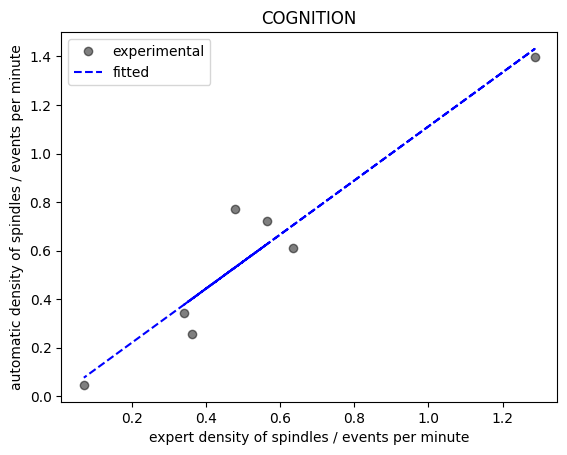

In [44]:
res = sst.linregress(annotationDensity, detectionDensity)
print(res)

print(np.mean(np.array(detectionDensity) - np.array(annotationDensity)))
plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.title("COGNITION")
plt.xlabel("expert density of spindles / events per minute")
plt.ylabel("automatic density of spindles / events per minute")
plt.show()

In [45]:
timesN2=[]
for ind, row in experimentModels.iterrows():
    hypnogram=loadCOGNITIONHypnogram(row.test,cognipath)
    timesN2.append(np.sum(hypnogram==2))
timesN2=np.array(timesN2)
timesN2=timesN2/200

detectionDensity=list(map(lambda x: len(x[0])/(x[1]/60),zip(allDetections_N2,timesN2)))
annotationDensity=list(map(lambda x: len(x[0])/(x[1]/60),zip(allAnnotations_N2,timesN2)))
detectionNumber=list(map(lambda x: len(x),allDetections_N2))
annotationNumber=list(map(lambda x: len(x),allAnnotations_N2))

experimentModels_N2['detectionNumber'] = detectionDensity
experimentModels_N2['annotationNumber'] = annotationDensity
experimentModels_N2['detectionDensity'] = detectionDensity
experimentModels_N2['annotationDensity'] = annotationDensity

LinregressResult(slope=1.0427471566146842, intercept=0.05371421099283702, rvalue=0.9318111669161434, pvalue=0.00224742374208704, stderr=0.1816373121560507, intercept_stderr=0.24386160478395855)
0.00224742374208704
0.10340672223563108


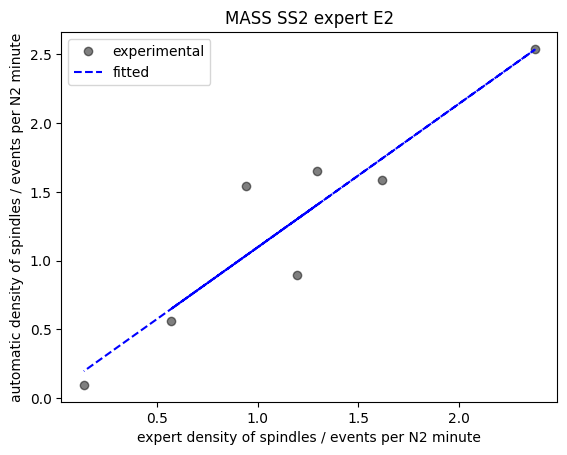

In [46]:
res=sst.linregress(annotationDensity,detectionDensity)
print(res)
print(res.pvalue)

print(np.mean(np.array(detectionDensity) - np.array(annotationDensity)))

plt.plot(annotationDensity,detectionDensity,linestyle='',marker='o',color='black',alpha=0.5,label='experimental')
plt.plot(annotationDensity, res.intercept + res.slope*np.array(annotationDensity), 'b', linestyle='--', label='fitted')
plt.legend()
plt.title("MASS SS2 expert E2")
plt.xlabel("expert density of spindles / events per N2 minute")
plt.ylabel("automatic density of spindles / events per N2 minute")
plt.show()

In [47]:
dumpPickle('experimentModels_ValidationperModel_Testing_E1_IoU-0.2_temp_oldF1.pkl',experimentModels)

In [48]:
experimentModels.columns

Index(['criteriumId', 'criteriumName', 'labelerIdList', 'train', 'val', 'test',
       'modelId', 'spindleTimeRate', 'rawF1', 'rawPrecision', 'rawRecall',
       'f1', 'precision', 'recall', 'eventF1', 'eventPrecision', 'eventRecall',
       'Binarization_Threshold', 'Boosting_Iterations', 'detectionNumber',
       'annotationNumber', 'detectionDensity', 'annotationDensity'],
      dtype='object')

## Results all

In [49]:
fig=px.scatter(experimentModels,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
fig=px.scatter(experimentModels,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

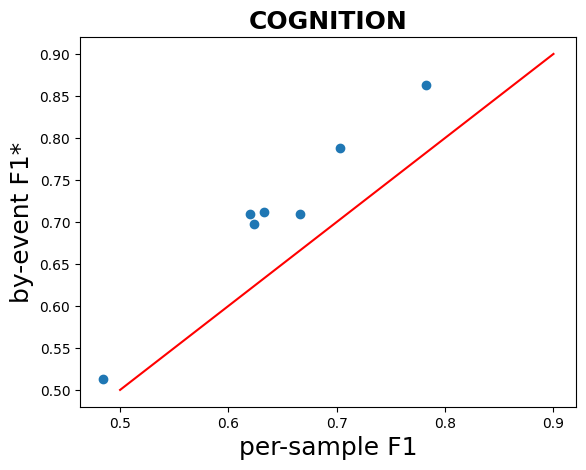

<Figure size 640x480 with 0 Axes>

In [50]:
ax=plt.subplot()

ax.scatter(experimentModels['rawF1'].to_numpy(), experimentModels['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("COGNITION", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#plt.savefig('per-sample_vs_by-event_Cognition_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}



In [51]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0002     1.0  0.697561 NaN  0.697561  0.697561  0.697561            1.0   
0003     1.0  0.862789 NaN  0.862789  0.862789  0.862789            1.0   
0004     1.0  0.788321 NaN  0.788321  0.788321  0.788321            1.0   
0005     1.0  0.709443 NaN  0.709443  0.709443  0.709443            1.0   
0006     1.0  0.712389 NaN  0.712389  0.712389  0.712389            1.0   
0007     1.0  0.709069 NaN  0.709069  0.709069  0.709069            1.0   
0008     1.0  0.512821 NaN  0.512821  0.512821  0.512821            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0002  0.841176 NaN  0.841176  0.841176  0.841176         1.0  0.595833 NaN   
0003  0.828633 NaN  0.828633  0.828633  0.828633         1.0  0.899882 NaN   
0004  0.803970 NaN  0.803970  0.803970  0.803970         1.0  0.773270 NaN   
0005  0.574510 NaN  0.574510  0.574510  0.574510         1.0  0.927215 NaN   
0006  0.712389 NaN  0.712389  0.712389  0.712389         1.0  0.712389 NaN   
0007  0.631027 NaN  0.631027  0.631027  0.631027         1.0  0.809140 NaN   
0008  0.645161 NaN  0.645161  0.645161  0.645161         1.0  0.425532 NaN   

                                    
           min       50%       max  
test                                
0002  0.595833  0.595833  0.595833  
0003  0.899882  0.899882  0.899882  
0004  0.773270  0.773270  0.773270  
0005  0.927215  0.927215  0.927215  
0006  0.712389  0.712389  0.712389  
0007  0.809140  0.809140  0.809140  
0008  0.425532  0.425532  0.425532

In [52]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0002,0.697561,0.841176,0.595833
1,0003,0.862789,0.828633,0.899882
2,0004,0.788321,0.803970,0.773270
3,0005,0.709443,0.574510,0.927215
4,0006,0.712389,0.712389,0.712389
5,0007,0.709069,0.631027,0.809140
6,0008,0.512821,0.645161,0.425532


In [53]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              2.857571e+23
eventF1           7.131991e-01
eventPrecision    7.195525e-01
eventRecall       7.347516e-01
dtype: float64

In [54]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_4200\2599554826.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.106809
eventPrecision    0.106675
eventRecall       0.176419
dtype: float64

In [55]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels.eventPrecision,
    'event F1':experimentModels.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels.eventRecall,
    'event F1':experimentModels.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [56]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [57]:
fig=px.scatter(experimentModels,x='rawF1',y='eventF1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()


## Restrict to only N2 stage


In [58]:
dumpPickle('experimentModelsTest_ValidationperModel_Testing_N2_E1_IoU-0.2_temp_oldF1.pkl',experimentModels_N2)

In [59]:
fig=px.scatter(experimentModels_N2,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['rawF1'], y=experimentModels_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

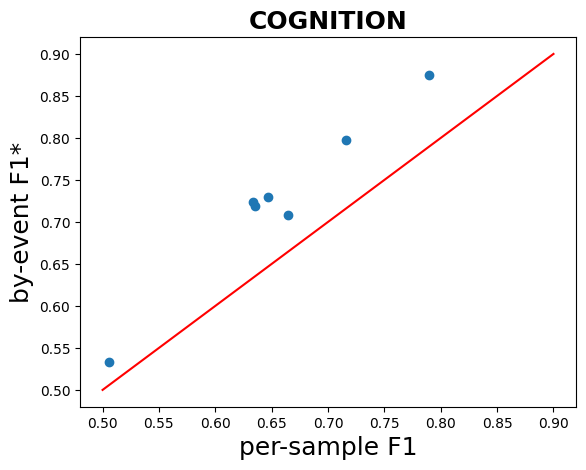

<Figure size 640x480 with 0 Axes>

In [60]:
ax=plt.subplot()

ax.scatter(experimentModels_N2['rawF1'].to_numpy(), experimentModels_N2['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("COGNITION", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#ax.savefig('per-sample_vs_by-event_Cognition_N2_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

In [61]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventPrecision',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [62]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [63]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0002     1.0  0.729970 NaN  0.729970  0.729970  0.729970            1.0   
0003     1.0  0.874330 NaN  0.874330  0.874330  0.874330            1.0   
0004     1.0  0.797403 NaN  0.797403  0.797403  0.797403            1.0   
0005     1.0  0.708075 NaN  0.708075  0.708075  0.708075            1.0   
0006     1.0  0.719048 NaN  0.719048  0.719048  0.719048            1.0   
0007     1.0  0.723508 NaN  0.723508  0.723508  0.723508            1.0   
0008     1.0  0.533333 NaN  0.533333  0.533333  0.533333            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0002  0.854167 NaN  0.854167  0.854167  0.854167         1.0  0.637306 NaN   
0003  0.846597 NaN  0.846597  0.846597  0.846597         1.0  0.903941 NaN   
0004  0.805774 NaN  0.805774  0.805774  0.805774         1.0  0.789203 NaN   
0005  0.571142 NaN  0.571142  0.571142  0.571142         1.0  0.931373 NaN   
0006  0.725962 NaN  0.725962  0.725962  0.725962         1.0  0.712264 NaN   
0007  0.645652 NaN  0.645652  0.645652  0.645652         1.0  0.822715 NaN   
0008  0.645161 NaN  0.645161  0.645161  0.645161         1.0  0.454545 NaN   

                                    
           min       50%       max  
test                                
0002  0.637306  0.637306  0.637306  
0003  0.903941  0.903941  0.903941  
0004  0.789203  0.789203  0.789203  
0005  0.931373  0.931373  0.931373  
0006  0.712264  0.712264  0.712264  
0007  0.822715  0.822715  0.822715  
0008  0.454545  0.454545  0.454545

In [64]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0002,0.729970,0.854167,0.637306
1,0003,0.874330,0.846597,0.903941
2,0004,0.797403,0.805774,0.789203
3,0005,0.708075,0.571142,0.931373
4,0006,0.719048,0.725962,0.712264
5,0007,0.723508,0.645652,0.822715
6,0008,0.533333,0.645161,0.454545


In [65]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              2.857571e+23
eventF1           7.265238e-01
eventPrecision    7.277794e-01
eventRecall       7.501924e-01
dtype: float64

In [66]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_4200\292585311.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.103771
eventPrecision    0.111268
eventRecall       0.165748
dtype: float64

In [67]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels_N2.eventPrecision,
    'event F1':experimentModels_N2.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels_N2.eventRecall,
    'event F1':experimentModels_N2.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [68]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()